In [1]:
# Repository locations
ATM_DATA_DIR = "/epyc/projects/atm/atm_data/"

from atm import __version__
print("ATM Version: {}".format(__version__))

ATM Version: 1.0


In [2]:
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set(font_scale=0.8, 
        context="paper", 
        style="ticks", 
        rc={"axes.linewidth": 0.8})
sns.set_palette("viridis")

%matplotlib inline

from atm.obs import WISE
from atm.models import NEATM
from atm.functions import calcQ
from atm.functions import calcFluxLambdaAtObsWithSunlight
from atm.analysis import calcColors
from atm.analysis import mergeResultsWithNEOWISE
from atm.analysis import crossmatchNEOWISE
from atm.plotting import plotHist

In [3]:
DPI = 300
SAVE_DIR = "../plots/"
FORMAT = "png"

SAVE_FIGS = False

In [4]:
SIGMA = 0.15
RUN_DIR = os.path.join(ATM_DATA_DIR, "paper1/runs/sigma{}".format(int(SIGMA * 100)))
RUN_NAME = "run1"

In [5]:
con = sql.connect(os.path.join(ATM_DATA_DIR, "paper1/sample.db"))

neowise_v2 = pd.read_sql("""SELECT * FROM neowise_v2""", con)
observations = pd.read_sql("""SELECT * FROM observations""", con)

In [6]:
neowise_v2["FIT_CODE"].value_counts()

DV--    104564
DVB-     67606
DVBI      5040
DV-I      2887
D---      1062
D-B-       384
DVF-        17
-VBI        13
-VB-        10
DVFI         5
D-BI         1
Name: FIT_CODE, dtype: int64

In [7]:
crossmatchNEOWISE(neowise_v2, observations[observations["keep"] == 1])

Crossmatched 7073 unique designations from observations with NEOWISE table.


In [8]:
results_database = os.path.join(RUN_DIR, "atm_results_{}.db".format(RUN_NAME))
merged_results, pp_dfs = mergeResultsWithNEOWISE(os.path.join(ATM_DATA_DIR, "paper1/sample.db"), 
                                                 results_database, 
                                                 minObs=3, 
                                                 neowiseTable="neowise_v2",
                                                 fitCodes=["DVBI"])

con = sql.connect(results_database)
observed_stats = pd.read_sql("""SELECT * FROM observed_stats""", con)
model_stats = pd.read_sql("""SELECT * FROM model_stats""", con)

There are 181589 fits for 141484 unique objects in the 2016 NEOWISE PDS table.
Selecting only fits with at least 3 observations in each band.
Selecting only fits with fit code(s): DVBI.
There are 3653 fits for 3390 unique objects.
3608 fits have been matched with an object in observations.
Sorting by number of observations and keeping the fits using the most observations...
Merging NEOWISE results with post-processed tables...

3334 fits have been found for 3334 unique objects in observations.
Done.



In [9]:
neowise_v2[~neowise_v2["matched_designation"].isna()]["FIT_CODE"].value_counts()

DV--    7355
DVBI    4350
DVB-    3415
DV-I    1643
-VBI      11
-VB-       7
D-B-       5
Name: FIT_CODE, dtype: int64

In [10]:
matched_fits = len(neowise_v2[(~neowise_v2["matched_designation"].isna()) & (neowise_v2["N_W1"] == 0)])
all_fits = len(neowise_v2[neowise_v2["N_W1"] == 0])
only_fits = len(neowise_v2[(neowise_v2["N_W1"] != 0) 
                         & (neowise_v2["N_W2"] == 0)
                         & (neowise_v2["N_W3"] == 0)
                         & (neowise_v2["N_W4"] == 0)])
print("Matched NEOWISE fits with no W1 observations: {}".format(matched_fits))
print("NEOWISE fits with no W1 observations: {} ({:.2f} %)".format(all_fits, all_fits / len(neowise_v2) * 100.0))
print("NEOWISE fits with only W1 observations: {} ({:.2f} %)".format(only_fits, only_fits / len(neowise_v2) * 100.0))

Matched NEOWISE fits with no W1 observations: 5592
NEOWISE fits with no W1 observations: 163536 (90.06 %)
NEOWISE fits with only W1 observations: 13 (0.01 %)


In [11]:
matched_fits = len(neowise_v2[(~neowise_v2["matched_designation"].isna()) & (neowise_v2["N_W2"] == 0)])
all_fits = len(neowise_v2[neowise_v2["N_W2"] == 0])
only_fits = len(neowise_v2[(neowise_v2["N_W1"] == 0) 
                         & (neowise_v2["N_W2"] != 0)
                         & (neowise_v2["N_W3"] == 0)
                         & (neowise_v2["N_W4"] == 0)])
print("Matched NEOWISE fits with no W2 observations: {}".format(matched_fits))
print("NEOWISE fits with no W2 observations: {} ({:.2f} %)".format(all_fits, all_fits / len(neowise_v2) * 100.0))
print("NEOWISE fits with only W2 observations: {} ({:.2f} %)".format(only_fits, only_fits / len(neowise_v2) * 100.0))

Matched NEOWISE fits with no W2 observations: 2162
NEOWISE fits with no W2 observations: 136996 (75.44 %)
NEOWISE fits with only W2 observations: 20735 (11.42 %)


In [12]:
matched_fits = len(neowise_v2[(~neowise_v2["matched_designation"].isna()) & (neowise_v2["N_W3"] == 0)])
all_fits = len(neowise_v2[neowise_v2["N_W3"] == 0])
only_fits = len(neowise_v2[(neowise_v2["N_W1"] == 0) 
                         & (neowise_v2["N_W2"] == 0)
                         & (neowise_v2["N_W3"] != 0)
                         & (neowise_v2["N_W4"] == 0)])
print("Matched NEOWISE fits with no W3 observations: {}".format(matched_fits))
print("NEOWISE fits with no W3 observations: {} ({:.2f} %)".format(all_fits, all_fits / len(neowise_v2) * 100.0))
print("NEOWISE fits with only W3 observations: {} ({:.2f} %)".format(only_fits, only_fits / len(neowise_v2) * 100.0))

Matched NEOWISE fits with no W3 observations: 8748
NEOWISE fits with no W3 observations: 33098 (18.23 %)
NEOWISE fits with only W3 observations: 74671 (41.12 %)


In [13]:
matched_fits = len(neowise_v2[(~neowise_v2["matched_designation"].isna()) & (neowise_v2["N_W4"] == 0)])
all_fits = len(neowise_v2[neowise_v2["N_W4"] == 0])
only_fits = len(neowise_v2[(neowise_v2["N_W1"] == 0) 
                         & (neowise_v2["N_W2"] == 0)
                         & (neowise_v2["N_W3"] == 0)
                         & (neowise_v2["N_W4"] != 0)])
print("Matched NEOWISE fits with no W1 observations: {}".format(matched_fits))
print("NEOWISE fits with no W4 observations: {} ({:.2f} %)".format(all_fits, all_fits / len(neowise_v2) * 100.0))
print("NEOWISE fits with only W4 observations: {} ({:.2f} %)".format(only_fits, only_fits / len(neowise_v2) * 100.0))

Matched NEOWISE fits with no W1 observations: 9166
NEOWISE fits with no W4 observations: 109660 (60.39 %)
NEOWISE fits with only W4 observations: 58 (0.03 %)


In [14]:
len(neowise_v2[(~neowise_v2["matched_designation"].isna()) 
               & (neowise_v2["N_W1"] > 0) 
               & (neowise_v2["N_W2"] > 0) 
               & (neowise_v2["N_W3"] > 0)
               & (neowise_v2["N_W4"] > 0)])

3865

In [15]:
neowise_v2[(~neowise_v2["matched_designation"].isna()) 
           & (neowise_v2["N_W1"] > 0) 
           & (neowise_v2["N_W2"] > 0) 
           & (neowise_v2["N_W3"] > 0) 
           & (neowise_v2["N_W4"] > 0)]["matched_designation"].nunique()

3591

Filtered results: 3334


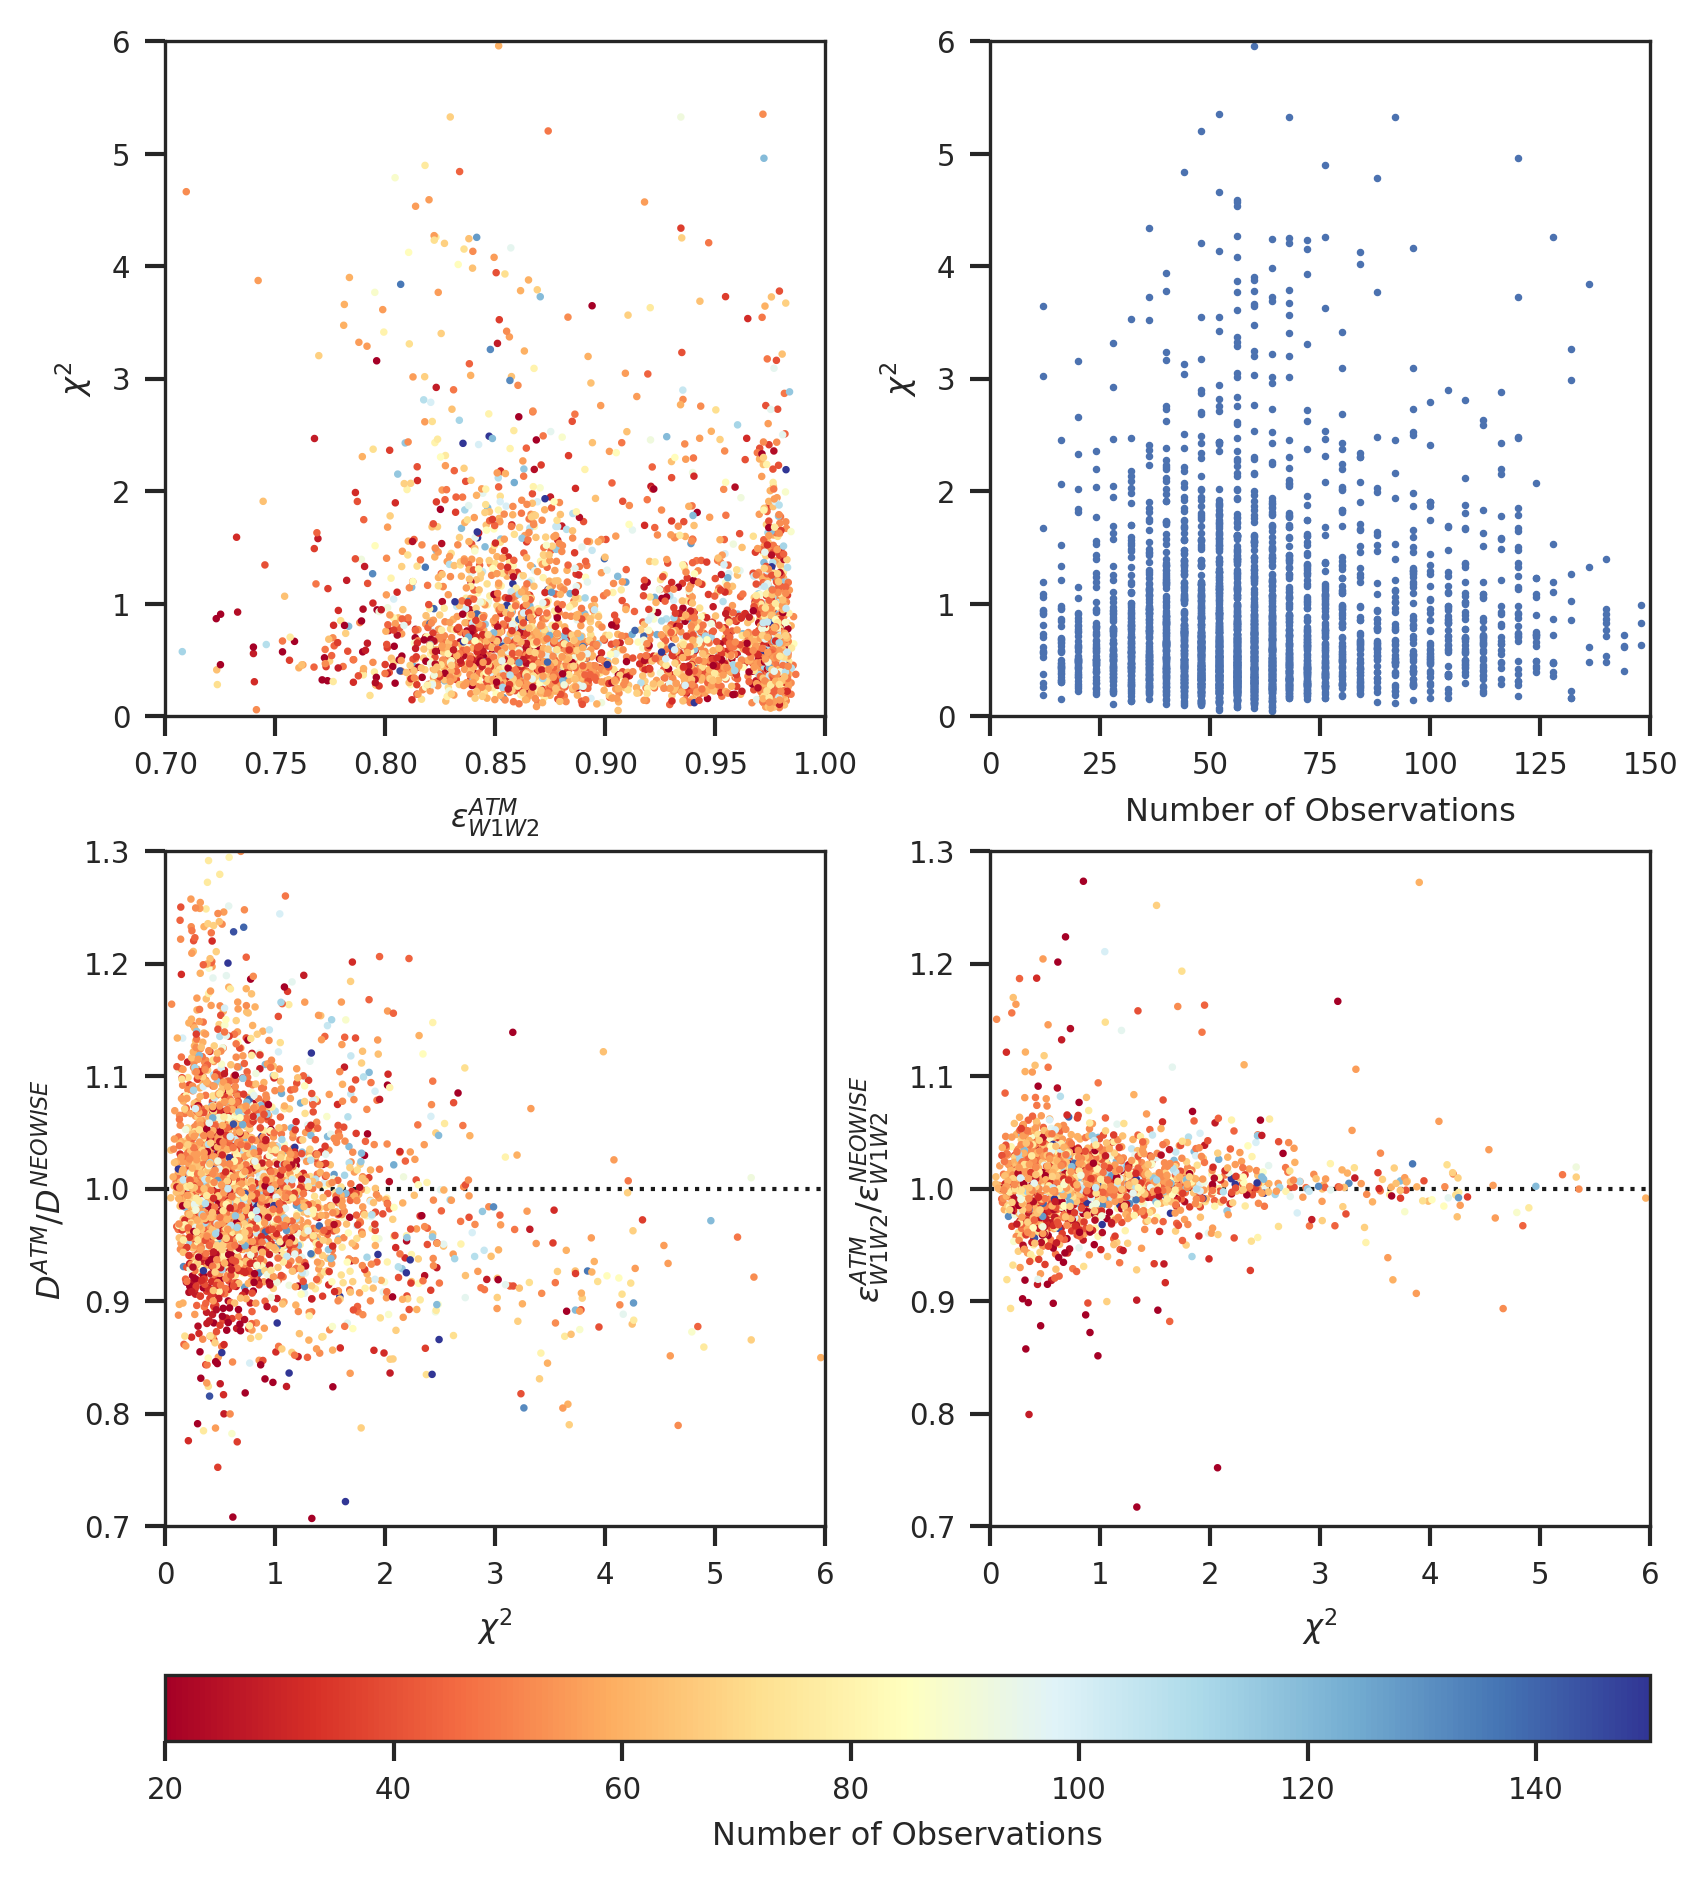

In [16]:
merged_results["eps_W1W2_NEOWISE"] = 1 - merged_results["IR_ALBEDO"] * calcQ(merged_results["SLOPE_PARAM"])

filtered_results = merged_results
print("Filtered results: {}".format(len(filtered_results)))

scatterKwargs = {
    "cmap" : "RdYlBu",
    "vmin" : 20,
    "vmax" : 150,
    "s": 1,
    "c": filtered_results["num_obs"].values
}

fig, ax = plt.subplots(2, 2, dpi=DPI, figsize=(5.5, 5.5))
fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.05,  
        # the right side of the subplots of the figure
        right=0.95,
        # the bottom of the subplots of the figure
        bottom=0.05,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.25,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.2)   
cm = ax[0,0].scatter(filtered_results["eps_W1W2_median"].values, 
                     filtered_results["reduced_chi2"].values,
                     **scatterKwargs)
ax[0,0].set_xlabel("$\epsilon_{W1W2}^{ATM}$")
ax[0,0].set_ylabel("$\chi^2$")
ax[0,0].set_ylim(0, 6)
ax[0,0].set_xlim(0.70, 1.0)

cm = ax[0,1].scatter(filtered_results["num_obs"].values, 
                     filtered_results["reduced_chi2"].values,
                     s=1,
                     c="b")
ax[0,1].set_xlabel("Number of Observations")
ax[0,1].set_ylabel("$\chi^2$")
ax[0,1].set_xlim(0, 150)
ax[0,1].set_ylim(0, 6)

cm = ax[1,0].scatter(filtered_results["reduced_chi2"].values, 
                     10**filtered_results["logD_median"].values / (filtered_results["DIAMETER"].values * 1000.), 
                     **scatterKwargs)
ax[1,0].hlines([1], 0, 6, linestyle=":", lw=1, color="k", zorder=0)
ax[1,0].set_xlabel("$\chi^2$")
ax[1,0].set_ylabel("$D^{ATM}/D^{NEOWISE}$")
ax[1,0].set_xlim(0, 6)
ax[1,0].set_ylim(0.7, 1.3)

cm = ax[1,1].scatter(filtered_results["reduced_chi2"].values, 
                     filtered_results["eps_W1W2_median"].values / (filtered_results["eps_W1W2_NEOWISE"].values), 
                     **scatterKwargs)
ax[1,1].hlines([1], 0, 6, linestyle=":", lw=1, color="k", zorder=0)
ax[1,1].set_xlabel("$\chi^2$")
ax[1,1].set_ylabel("$\epsilon_{W1W2}^{ATM}/\epsilon_{W1W2}^{NEOWISE}$")
ax[1,1].set_xlim(0, 6)
ax[1,1].set_ylim(0.7, 1.3)

cbar_ax = fig.add_axes([0.05, -0.08, 0.90, 0.04])
fig.colorbar(cm, 
             cax=cbar_ax, 
             label=r"Number of Observations", 
             orientation="horizontal")
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "chi2_num_obs.{}".format(FORMAT)),
            bbox_inches='tight')

Filtered results: 3334
14 values are outside the defined minimum and maximum.
14 values are outside the defined minimum and maximum.
Statistics will be calculated between 0.0 and 3.0
6 values are outside the defined minimum and maximum.


/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(xValues, bins=np.linspace(xRange[0], xRange[1], bins), **histKwargs)
/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(xValues, bins=np.linspace(xRange[0], xRange[1], bins), **histKwargs)
/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(xValues, bins=np.linspace(xRange[0], xRange[1], bins), **histKwargs)
/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(x

22 values are outside the defined minimum and maximum.
14 values are outside the defined minimum and maximum.
Statistics will be calculated between 0.0 and 3.0
4 values are outside the defined minimum and maximum.


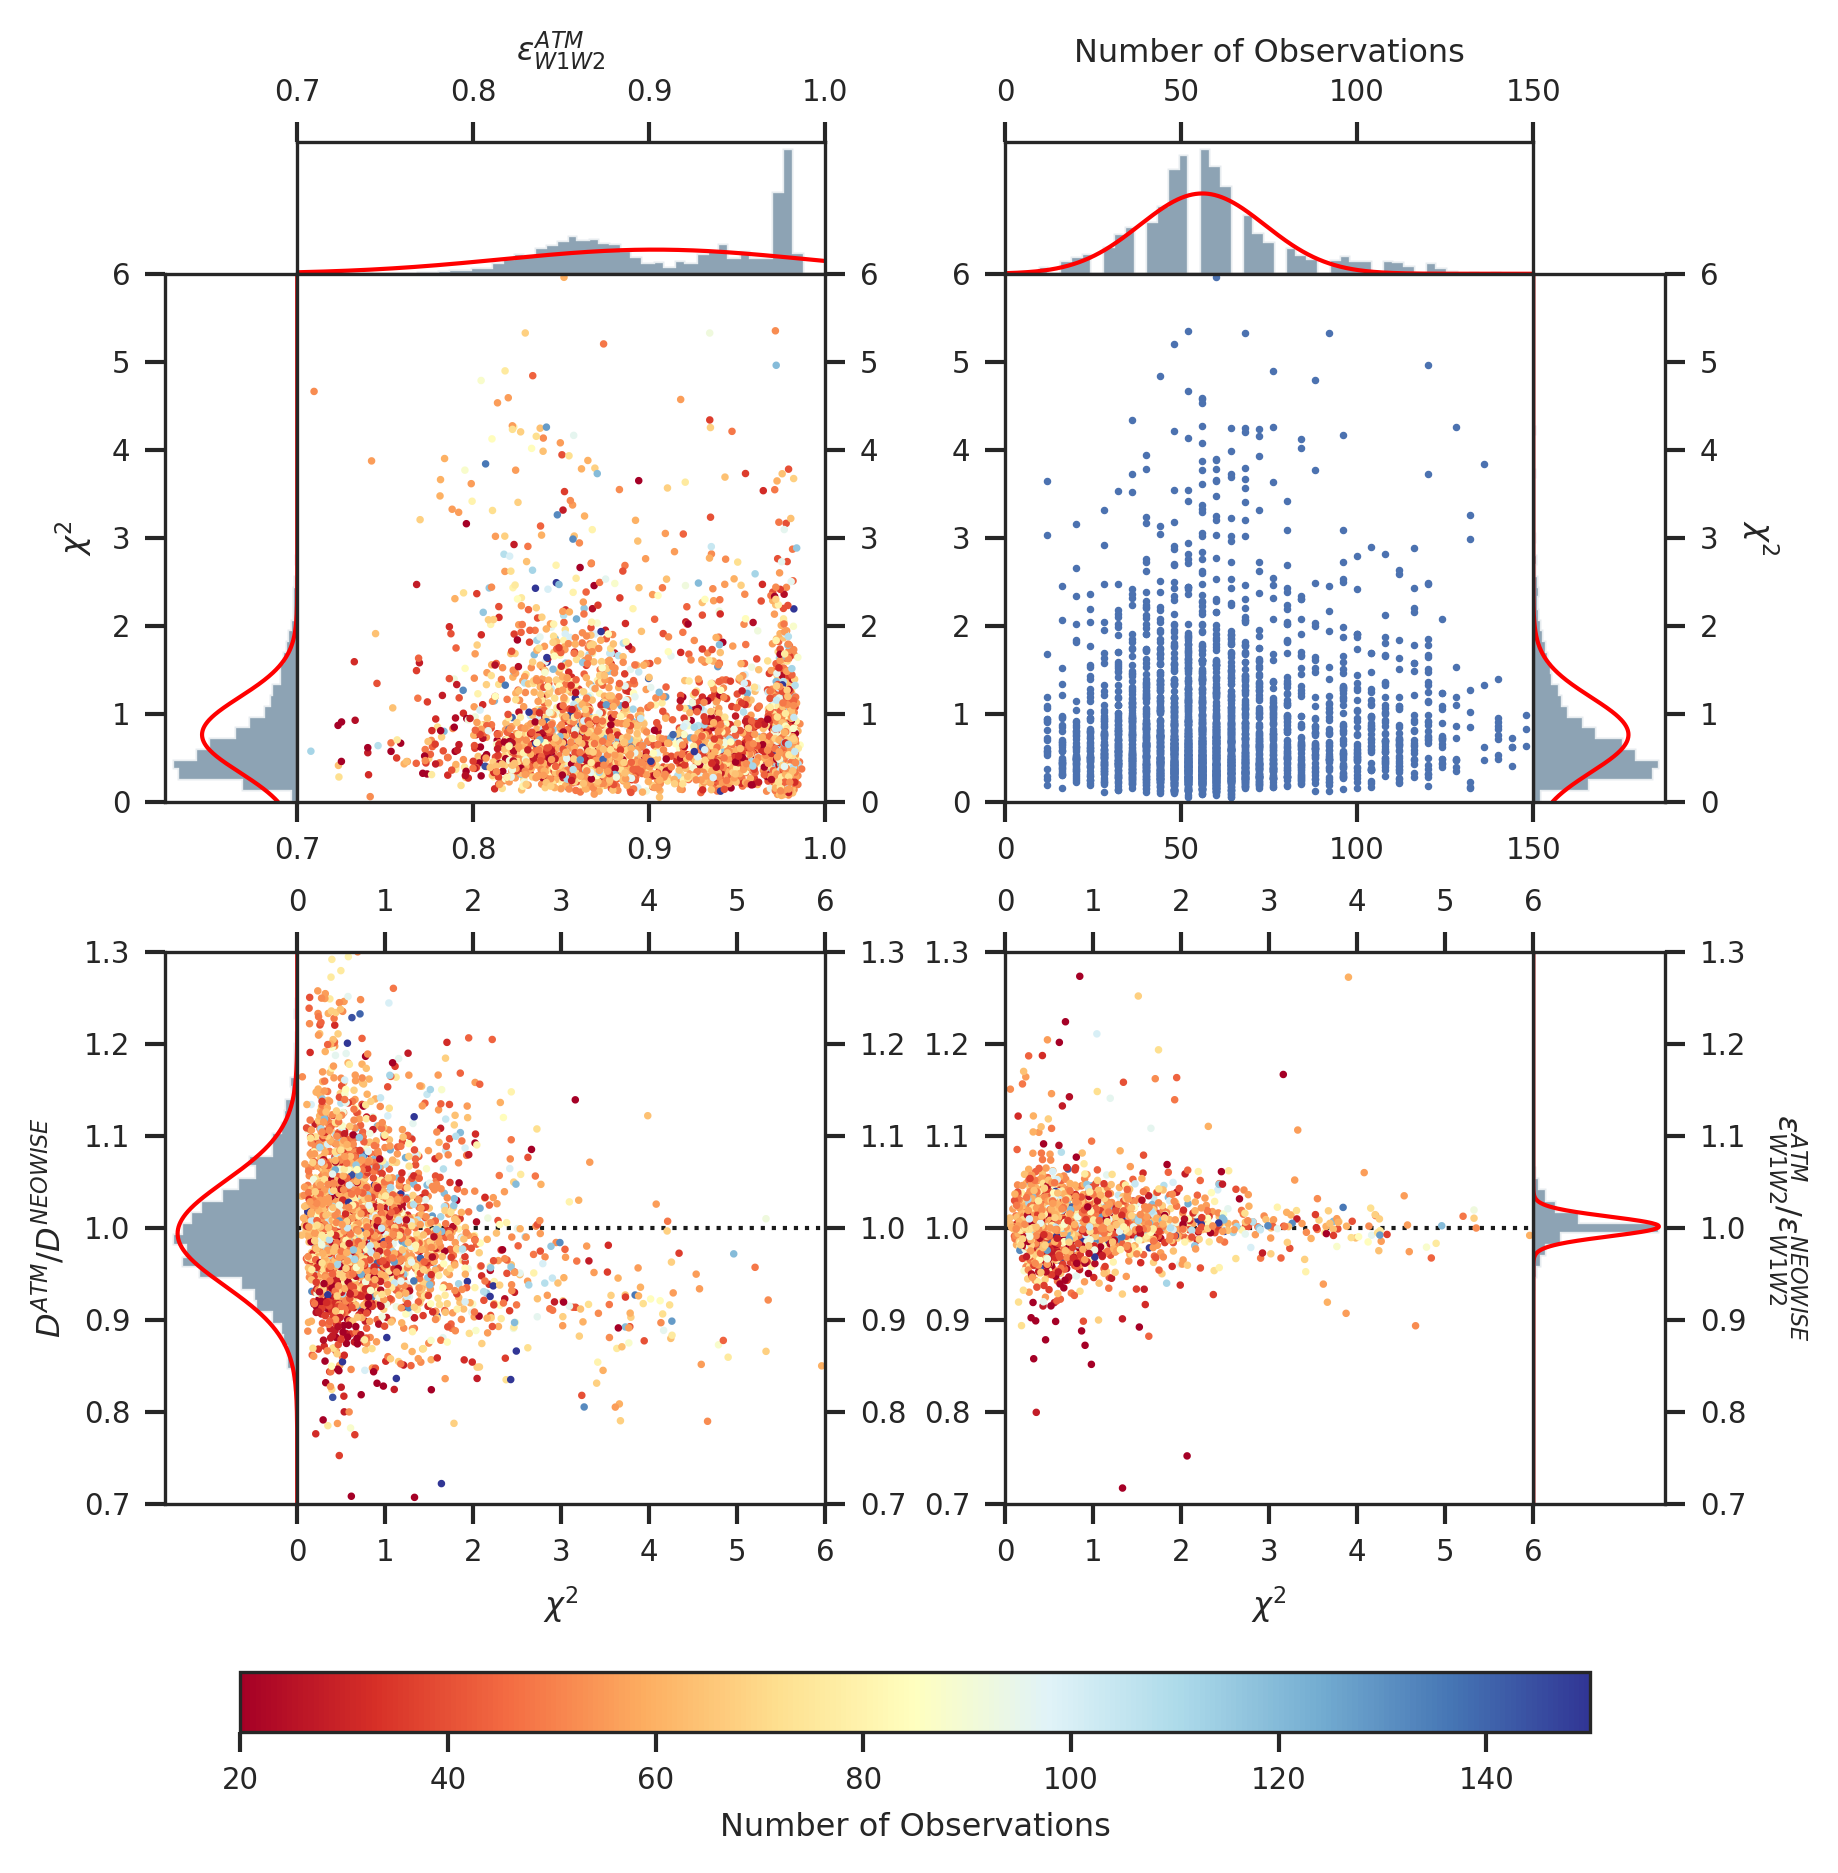

In [17]:
merged_results["eps_W1W2_NEOWISE"] = 1 - merged_results["IR_ALBEDO"] * calcQ(merged_results["SLOPE_PARAM"])

filtered_results = merged_results
print("Filtered results: {}".format(len(filtered_results)))

scatterKwargs = {
    "cmap" : "RdYlBu",
    "vmin" : 20,
    "vmax" : 150,
    "s": 1,
    "c": filtered_results["num_obs"].values
}

histKwargs = {
    "histtype" : "stepfilled",
    "color" : "#718CA1",
    "alpha" : 0.8, 
    "normed" : True,
}

histKwargs_s = {
    "histtype" : "stepfilled",
    "color" : "#718CA1",
    "alpha" : 0.8, 
    "normed" : True,
    "orientation" : "horizontal",
}

plotKwargs = {
    "ls" : "-",
    "lw" : 1,
    "c" : "red",
}

plotKwargsComponents = {
    "ls" : ":",
    "lw" : 1,
    "c" : "red",
    "alpha" : 0.8
}

verticalLines = {
    "lw" : 0.5,
    "linestyle" : ":",
}

fig = plt.figure(dpi=DPI, figsize=(5,5))

### Top left 
gs_lt = gridspec.GridSpec(5,5)
gs_lt.update(left=0.0, right=0.44, top=1.0, bottom=0.56)
gs_lt.update(wspace=0.0, hspace=0.0)
ax1 = fig.add_subplot(gs_lt[0, 1:])
ax2 = fig.add_subplot(gs_lt[1:, 0])
ax3 = fig.add_subplot(gs_lt[1:, 1:], sharex=ax1, sharey=ax2)

cm = ax3.scatter(filtered_results["eps_W1W2_median"].values, 
                 filtered_results["reduced_chi2"].values,
                 **scatterKwargs)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.set_ylim(0, 6)
ax3.set_xlim(0.70, 1.0)

ax1, stats = plotHist(ax1, 
                      filtered_results["eps_W1W2_median"], 
                      [0.7, 1.0], 
                      numGauss=1, 
                      bins=50,
                      histKwargs=histKwargs,
                      plotKwargs=plotKwargs)
ax1.set_xlabel("$\epsilon_{W1W2}^{ATM}$")
ax1.xaxis.set_label_position("top")
ax1.xaxis.tick_top()
ax1.set_yticks([])

ax2, stats = plotHist(ax2, 
                      filtered_results["reduced_chi2"], 
                      [0.0, 6.0], 
                      numGauss=1, 
                      bins=50,
                      swapAxes=True,
                      useMedian=False,
                      statRange=[0.0,3.0],
                      histKwargs=histKwargs_s,
                      plotKwargs=plotKwargs)
ax2.set_ylabel(r"$\chi^2$")
ax2.invert_xaxis()
ax2.set_xticks([])

### Bottom left
gs_lb = gridspec.GridSpec(5,5)
gs_lb.update(left=0.0, right=0.44, top=0.46, bottom=0.0)
gs_lb.update(wspace=0.0, hspace=0.0)
#ax4 = fig.add_subplot(gs_lb[-1, 1:])
ax5 = fig.add_subplot(gs_lb[:-1, 0])
ax6 = fig.add_subplot(gs_lb[:-1, 1:], sharey=ax5)


cm = ax6.scatter(filtered_results["reduced_chi2"].values, 
                 10**filtered_results["logD_median"].values / (filtered_results["DIAMETER"].values * 1000.), 
                 **scatterKwargs)
ax6.hlines([1], 0, 6, linestyle=":", lw=1, color="k", zorder=0)
ax6.tick_params(labeltop=True, labelbottom=True, 
                top=True, bottom=True, 
                right=True, labelright=True,
                left=False, labelleft=False)
ax6.set_xticks(np.arange(0.0, 7))
ax6.set_xlabel(r"$\chi^2$")
ax6.set_xlim(0, 6)
ax6.set_ylim(0.7, 1.3)

#ax4, stats = plotHist(ax4, 
#                      filtered_results["reduced_chi2"].values, 
#                      [0.0, 6], 
#                      numGauss=1, 
#                      bins=50,
#                      histKwargs=histKwargs,
#                      plotKwargs=plotKwargs)
#ax4.set_xlabel(r"$\chi^2$")
#ax4.invert_yaxis()
#ax4.set_yticks([])
#ax4.set_xticks(np.arange(0.0, 7))

ax5, stats = plotHist(ax5, 
                      10**filtered_results["logD_median"].values / (filtered_results["DIAMETER"].values * 1000.), 
                      [0.7, 1.3], 
                      numGauss=1, 
                      bins=50,
                      swapAxes=True,
                      histKwargs=histKwargs_s,
                      plotKwargs=plotKwargs)
ax5.set_ylabel("$D^{ATM}/D^{NEOWISE}$")
ax5.invert_xaxis()
ax5.set_xticks([])

### Top right
gs_rt = gridspec.GridSpec(5,5)
gs_rt.update(left=0.56, right=1.0, top=1.0, bottom=0.56)
gs_rt.update(wspace=0.0, hspace=0.0)
ax7 = fig.add_subplot(gs_rt[0, :-1])
ax8 = fig.add_subplot(gs_rt[1:, -1])
ax9 = fig.add_subplot(gs_rt[1:, :-1], sharex=ax7, sharey=ax8)

cm = ax9.scatter(filtered_results["num_obs"].values, 
                 filtered_results["reduced_chi2"].values,
                 s=1,
                 c="b")
ax9.set_xlim(0, 150)
ax9.set_ylim(0, 6)

ax7, stats = plotHist(ax7, 
                      filtered_results["num_obs"].values, 
                      [0.0, 150], 
                      numGauss=1, 
                      bins=50,
                      histKwargs=histKwargs,
                      plotKwargs=plotKwargs)
ax7.set_xlabel("Number of Observations")
ax7.xaxis.set_label_position("top")
ax7.xaxis.tick_top()
ax7.set_yticks([])

ax8, stats = plotHist(ax8, 
                      filtered_results["reduced_chi2"].values, 
                      [0.0, 6.0], 
                      numGauss=1, 
                      bins=50,
                      swapAxes=True,
                      useMedian=False,
                      statRange=[0.0,3.0],
                      histKwargs=histKwargs_s,
                      plotKwargs=plotKwargs)
ax8.set_ylabel(r"$\chi^2$", rotation=-90, labelpad=15)
ax8.yaxis.set_label_position("right")
ax8.yaxis.tick_right()
ax8.set_xticks([])



gs_rb = gridspec.GridSpec(5,5)
gs_rb.update(left=0.56, right=1.0, top=0.46, bottom=0.0)
gs_rb.update(wspace=0.0, hspace=0.0)
#ax10 = fig.add_subplot(gs_rb[-1, :-1])
ax11 = fig.add_subplot(gs_rb[:-1, -1])
ax12 = fig.add_subplot(gs_rb[:-1, :-1], sharey=ax11)

cm = ax12.scatter(filtered_results["reduced_chi2"].values, 
                  filtered_results["eps_W1W2_median"].values / (filtered_results["eps_W1W2_NEOWISE"].values), 
                  **scatterKwargs)
ax12.hlines([1], 0, 6, linestyle=":", lw=1, color="k", zorder=0)
ax12.set_xlim(0, 6)
ax12.set_ylim(0.7, 1.3)
ax12.tick_params(labeltop=True, labelbottom=True, top=True, bottom=True)
ax12.set_xticks(np.arange(0.0, 7))
ax12.set_xlabel(r"$\chi^2$")

#ax10, stats = plotHist(ax10, 
#                      filtered_results["reduced_chi2"].values, 
#                      [0.0, 6.0], 
#                      numGauss=1, 
#                      bins=50,
#                      histKwargs=histKwargs,
#                      plotKwargs=plotKwargs)
#ax10.set_xlabel(r"$\chi^2$")
#ax10.invert_yaxis()
#ax10.set_xticks(np.arange(0.0, 7))
#ax10.set_yticks([])

ax11, stats = plotHist(ax11, 
                      filtered_results["eps_W1W2_median"].values / (filtered_results["eps_W1W2_NEOWISE"].values), 
                      [0.7, 1.3], 
                      numGauss=1, 
                      bins=50,
                      swapAxes=True,
                      histKwargs=histKwargs_s,
                      plotKwargs=plotKwargs)
ax11.set_ylabel("$\epsilon_{W1W2}^{ATM}/\epsilon_{W1W2}^{NEOWISE}$", rotation=-90, labelpad=15)
ax11.yaxis.set_label_position("right")
ax11.yaxis.tick_right()
ax11.set_xticks([])

cbar_ax = fig.add_axes([0.05, -0.06, 0.90, 0.04])
fig.colorbar(cm, 
             cax=cbar_ax, 
             label=r"Number of Observations", 
             orientation="horizontal")
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "chi2_num_obs_hists_all.{}".format(FORMAT)),
            bbox_inches='tight')

In [18]:
# Full sample
model_stats["reduced_chi2"].mean()

1.7579728250525986

In [19]:
# DVBI matched
filtered_results["reduced_chi2"].mean()

0.8666604497485398

Filtered results: 3072
3 values are outside the defined minimum and maximum.
17 values are outside the defined minimum and maximum.
19 values are outside the defined minimum and maximum.


/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(xValues, bins=np.linspace(xRange[0], xRange[1], bins), **histKwargs)
/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(xValues, bins=np.linspace(xRange[0], xRange[1], bins), **histKwargs)
/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(xValues, bins=np.linspace(xRange[0], xRange[1], bins), **histKwargs)
/epyc/projects/atm/envs/atm_py36/lib/python3.6/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, t

mu : 0.852
sigma : 0.020
weight : 0.187

mu : 0.977
sigma : 0.004
weight : 0.274

mu : 0.893
sigma : 0.050
weight : 0.538

31 values are outside the defined minimum and maximum.
mu : 0.365
sigma : 0.081
weight : 0.526

mu : 0.061
sigma : 0.010
weight : 0.283

mu : 0.145
sigma : 0.038
weight : 0.192



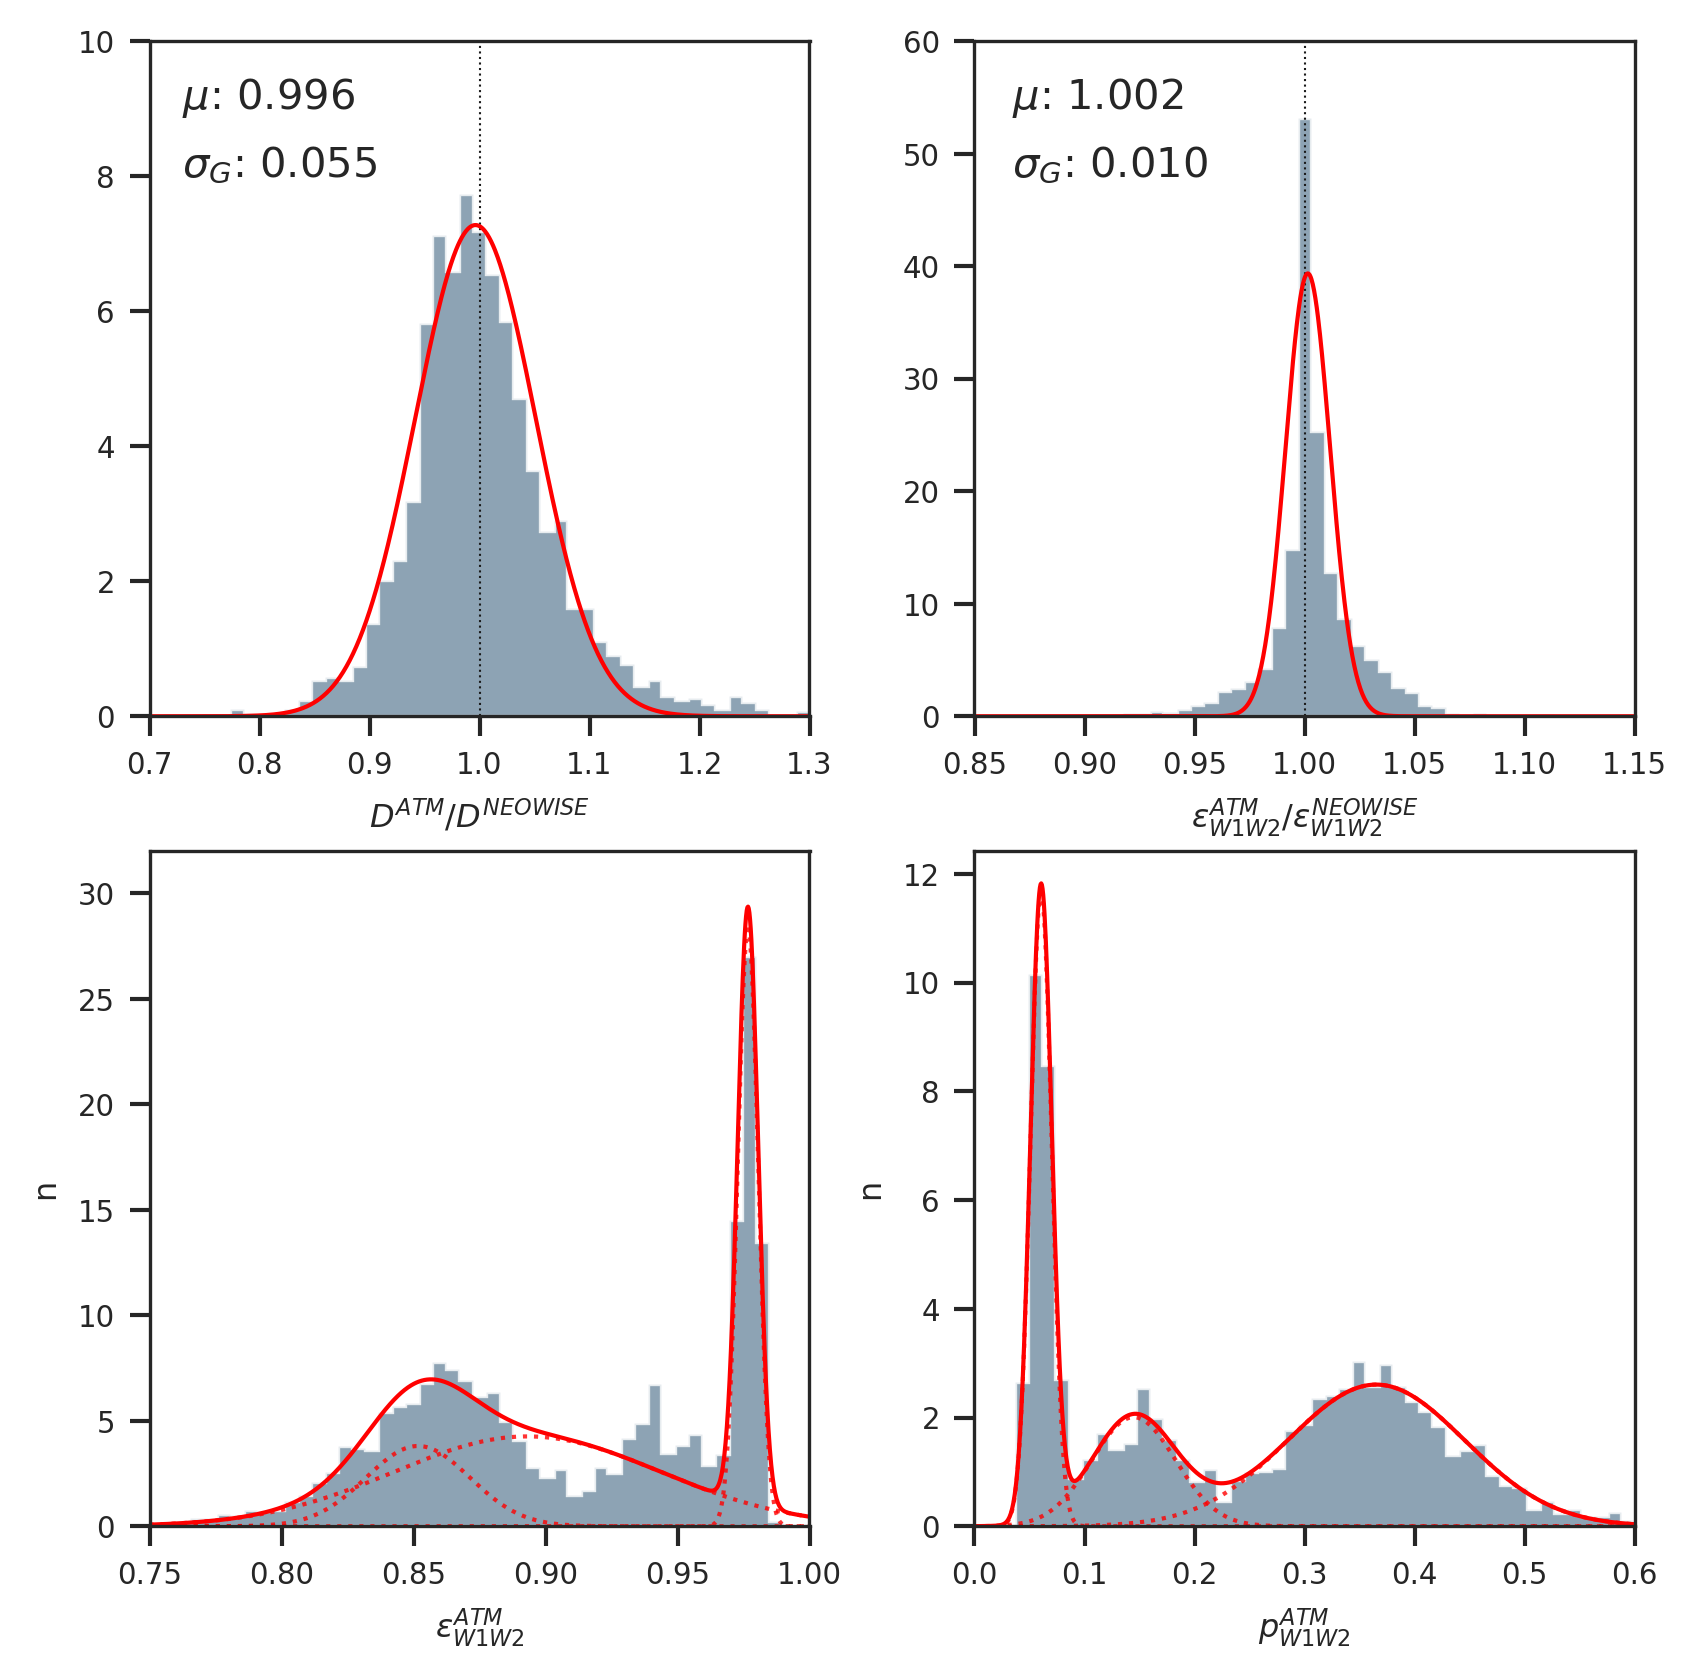

In [20]:
merged_results["eps_W1W2_NEOWISE"] = 1 - merged_results["IR_ALBEDO"] * calcQ(merged_results["SLOPE_PARAM"])
merged_results["p_W1W2_median"] = (1 - merged_results["eps_W1W2_median"]) / calcQ(merged_results["G_median"])

filtered_results = merged_results[(merged_results["num_obs"] >= 28)
                                  & (merged_results["reduced_chi2"] < 3)]
print("Filtered results: {}".format(len(filtered_results)))

histKwargs = {
    "histtype" : "stepfilled",
    "color" : "#718CA1",
    "alpha" : 0.8, 
    "normed" : True,
}
plotKwargs = {
    "ls" : "-",
    "lw" : 1,
    "c" : "red"
}

plotKwargsComponents = {
    "ls" : ":",
    "lw" : 1,
    "c" : "red",
    "alpha" : 0.8
}

verticalLines = {
    "lw" : 0.5,
    "linestyle" : ":",
}

fig, ax = plt.subplots(2, 2, dpi=DPI, figsize=(5.5, 5.5))
fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.05,  
        # the right side of the subplots of the figure
        right=0.95,
        # the bottom of the subplots of the figure
        bottom=0.05,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.25,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.2)   
ax[0,0], stats = plotHist(ax[0,0], 
                         10**filtered_results["logD_median"].values / (filtered_results["DIAMETER"].values * 1000.), 
                         [0.7, 1.3], 
                         numGauss=1, 
                         bins=50,
                         histKwargs=histKwargs,
                         plotKwargs=plotKwargs)
ax[0,0].vlines([1.0], 0, 10, **verticalLines)
ax[0,0].set_xlabel(r"$D^{ATM} / D^{NEOWISE}$")
ax[0,0].set_xlim(0.7, 1.3)
ax[0,0].set_ylim(0, 10)
ax[0,0].text(0.73, 9.0, r"$\mu$: {:.3f}".format(stats[0]))
ax[0,0].text(0.73, 8.0, r"$\sigma_G$: {:.3f}".format(stats[1]))


ax[0,1], stats = plotHist(ax[0,1], 
                         filtered_results["eps_W1W2_median"].values / filtered_results["eps_W1W2_NEOWISE"].values, 
                         [0.85, 1.15], 
                         numGauss=1, 
                         bins=50,
                         histKwargs=histKwargs,
                         plotKwargs=plotKwargs)
ax[0,1].vlines([1.0], 0, 60, **verticalLines)
ax[0,1].set_xlabel(r"$\epsilon^{ATM}_{W1W2} / \epsilon^{NEOWISE}_{W1W2}$")
ax[0,1].set_xlim(0.85, 1.15)
ax[0,1].set_ylim(0, 60)
ax[0,1].text(0.867, 54, r"$\mu$: {:.3f}".format(stats[0]))
ax[0,1].text(0.867, 48, r"$\sigma_G$: {:.3f}".format(stats[1]))

ax[1,0], stats = plotHist(ax[1,0], 
                          filtered_results["eps_W1W2_median"].values, 
                          [0.75, 1], 
                          numGauss=3, 
                          bins=50,
                          histKwargs=histKwargs,
                          plotKwargs=plotKwargs,
                          plotKwargsComponents=plotKwargsComponents)
ax[1,0].set_xlabel("$\epsilon^{ATM}_{W1W2}$")
ax[1,0].set_ylabel("n")
ax[1,0].set_ylim(0, 32)
ax[1,0].set_xlim(0.75, 1.0)
for gauss in stats:
    print("mu : {:.3f}".format(gauss[0]))
    print("sigma : {:.3f}".format(gauss[1]))
    print("weight : {:.3f}".format(gauss[2]))
    print("")
    
ax[1,1], stats = plotHist(ax[1,1], 
                          filtered_results["p_W1W2_median"].values, 
                          [0, 0.6], 
                          numGauss=3,
                          bins=50,
                          histKwargs=histKwargs,
                          plotKwargs=plotKwargs,
                          plotKwargsComponents=plotKwargsComponents)
ax[1,1].set_xlabel("$p^{ATM}_{W1W2}$")
ax[1,1].set_ylabel("n")#
ax[1,1].set_xlim(0.0, 0.6)
for gauss in stats:
    print("mu : {:.3f}".format(gauss[0]))
    print("sigma : {:.3f}".format(gauss[1]))
    print("weight : {:.3f}".format(gauss[2]))
    print("")

if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "diameter_emissivity_albedo.{}".format(FORMAT)),
                bbox_inches='tight')

In [21]:
model = NEATM(verbose=False)
obs = WISE()

D = 10000.
G = 0.15
alpha_rad = pp_dfs[0]["alpha_rad"].median()
r = np.linspace(1.5, 5.5, 46)

track_dict = {
    "track1a" : {
        "T1" : 406,
        "eps_W1" : 0.977,  
        "eps_W2" : 0.977, 
        "eps_W3" : 0.80,
        "eps_W4" : 0.98,
    },
    
    "track1b" : {
        "T1" : 406,
        "eps_W1" : 0.977,  
        "eps_W2" : 0.977, 
        "eps_W3" : 0.90,
        "eps_W4" : 0.90,
    },
    
    "track2a" : {
        "T1" : 399,
        "eps_W1" : 0.946,  
        "eps_W2" : 0.946, 
        "eps_W3" : 0.80,
        "eps_W4" : 0.98,
    },
    
    "track2b" : {
        "T1" : 399,
        "eps_W1" : 0.946,  
        "eps_W2" : 0.946, 
        "eps_W3" : 0.90,
        "eps_W4" : 0.90,
    },
    
    "track3a" : {
        "T1" : 391,
        "eps_W1" : 0.863,  
        "eps_W2" : 0.863, 
        "eps_W3" : 0.80,
        "eps_W4" : 0.98,
    },
    
    "track3b" : {
        "T1" : 391,
        "eps_W1" : 0.863,  
        "eps_W2" : 0.863, 
        "eps_W3" : 0.90,
        "eps_W4" : 0.90,
    },  
}

lambd = obs.filterEffectiveLambdas
num_lambds = len(lambd)

track_df = []
for track in track_dict.keys():
    for r_i in r:
        # Make array of assumed emissivities
        eps = np.array([
            track_dict[track]["eps_W1"], 
            track_dict[track]["eps_W2"], 
            track_dict[track]["eps_W3"], 
            track_dict[track]["eps_W4"]
        ])
        # Calculate albedo
        albedo = (1 - eps) / calcQ(G)
        
        # Calculate flux at 4 WISE bands
        flux = calcFluxLambdaAtObsWithSunlight(
            model, 
            r_i * np.ones(num_lambds),
            (r_i - 1) * np.ones(num_lambds),
            lambd,
            track_dict[track]["T1"] / np.sqrt(r_i) * np.ones(num_lambds),
            D * np.ones(num_lambds),
            alpha_rad * np.ones(num_lambds),
            eps,
            albedo,
            G * np.ones(num_lambds))

        # Convert to magnitudes and add to a DataFrame
        mag = obs.convertFluxLambdaToMag(flux.T)
        track_df.append(pd.DataFrame({
            "track" : [track],
            "r_au" : [r_i],
            "mag_W1" : [mag[0]],
            "mag_W2" : [mag[1]],
            "mag_W3" : [mag[2]],
            "mag_W4" : [mag[3]]}))

tracks = pd.concat(track_df)
tracks.reset_index(inplace=True, drop=True)
tracks["obs_id"] = np.arange(1, len(tracks) + 1)

# Calculate colors
colors = calcColors(obs, tracks)
tracks = tracks.merge(colors, on="obs_id")

Calculating colors using these columns:
Magnitudes : mag_W1, mag_W2, mag_W3, mag_W4
Creating colors: W1-W2, W2-W3, W3-W4
Done.



In [22]:
def _plotTracks(ax, xCol, yCol):
    ax.plot(tracks[tracks["track"] == "track1a"][xCol].values,
            tracks[tracks["track"] == "track1a"][yCol].values,
            c="k")
    ax.plot(tracks[tracks["track"] == "track1b"][xCol].values,
            tracks[tracks["track"] == "track1b"][yCol].values,
            c="k",
            ls="--")
    ax.plot(tracks[tracks["track"] == "track2a"][xCol].values,
            tracks[tracks["track"] == "track2a"][yCol].values,
            c="r")
    ax.plot(tracks[tracks["track"] == "track2b"][xCol].values,
            tracks[tracks["track"] == "track2b"][yCol].values,
            c="r",
            ls="--")
    ax.plot(tracks[tracks["track"] == "track3a"][xCol].values,
            tracks[tracks["track"] == "track3a"][yCol].values,
            c="#001c7f")
    ax.plot(tracks[tracks["track"] == "track3b"][xCol].values,
            tracks[tracks["track"] == "track3b"][yCol].values,
            c="#001c7f",
            ls="--")

Filtered results: 3072


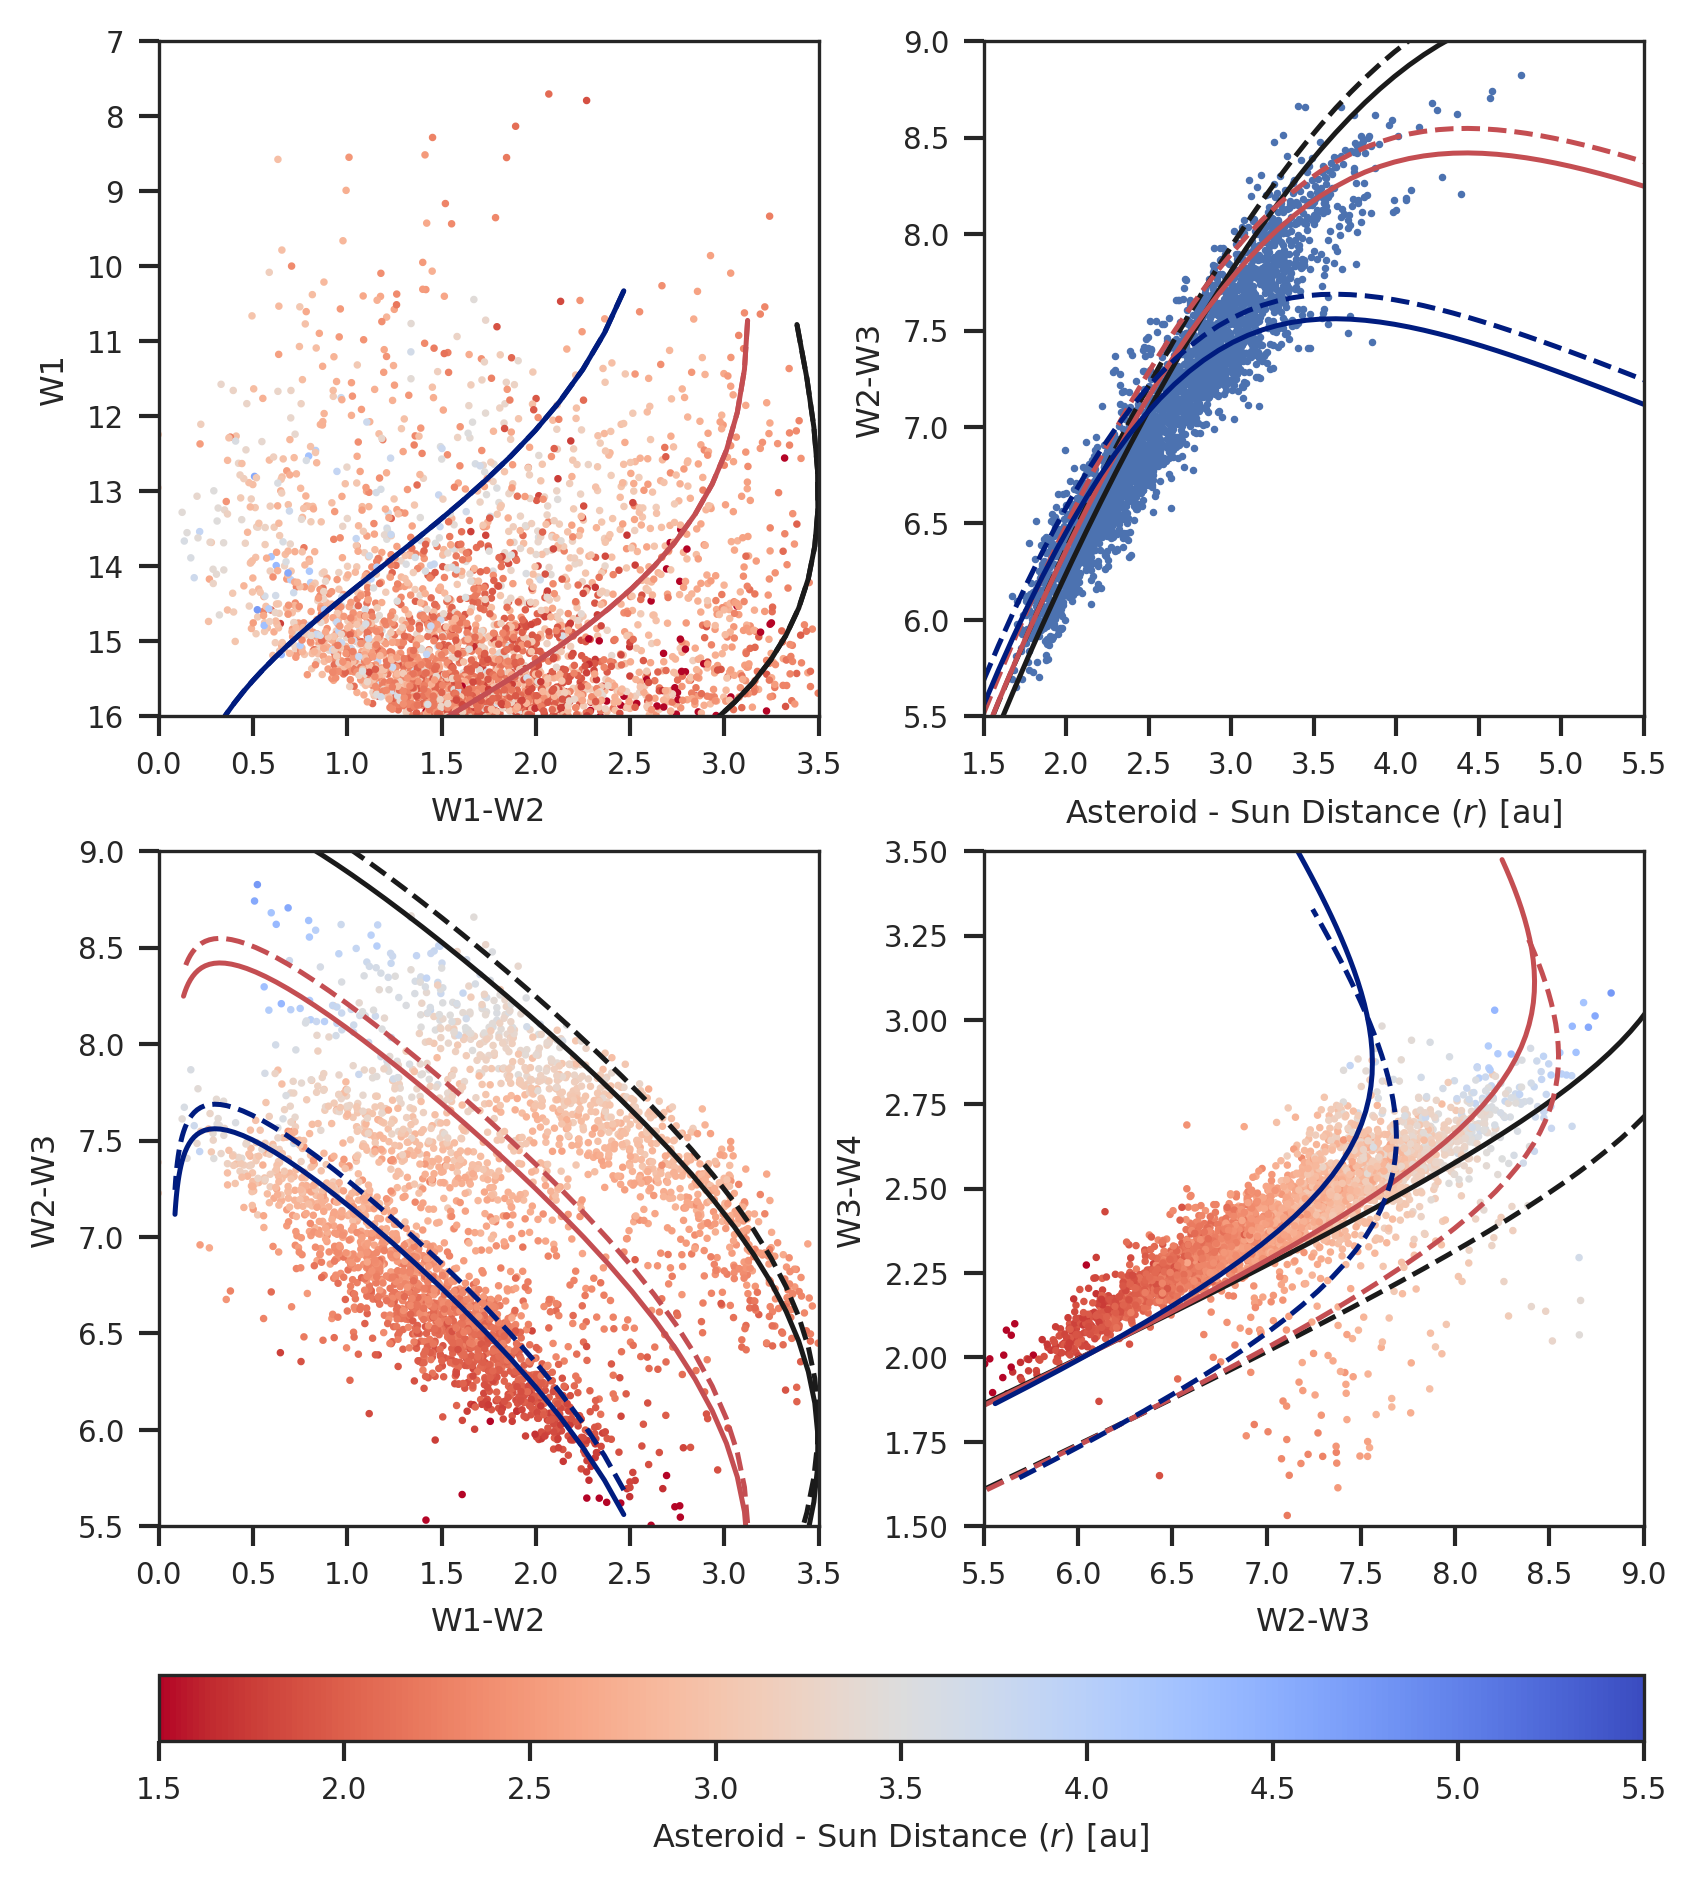

In [23]:
filtered_results = merged_results[(merged_results["num_obs"] >= 28)
                                  & (merged_results["reduced_chi2"] < 3)]
print("Filtered results: {}".format(len(filtered_results)))

scatterKwargs = {
    "cmap" : "coolwarm_r",
    "vmin" : 1.5,
    "vmax" : 5.5,
    "s": 1,
    "c": filtered_results["r_au_median"].values
}

fig, ax = plt.subplots(2, 2, dpi=DPI, figsize=(5.5, 5.5))
fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.05,  
        # the right side of the subplots of the figure
        right=0.95,
        # the bottom of the subplots of the figure
        bottom=0.05,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.25,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.2)   
cm = ax[0,0].scatter(filtered_results["W1-W2_median"].values, 
                     filtered_results["mag_W1_median"].values,
                     **scatterKwargs)
_plotTracks(ax[0,0], "W1-W2", "mag_W1")
ax[0,0].set_xlabel("W1-W2")
ax[0,0].set_ylabel("W1")
ax[0,0].set_xlim(0, 3.5)
ax[0,0].set_ylim(7, 16)
ax[0,0].invert_yaxis()

cm = ax[0,1].scatter(filtered_results["r_au_median"].values, 
                     filtered_results["W2-W3_median"].values, 
                     s=1, 
                     c="b")
_plotTracks(ax[0,1], "r_au", "W2-W3")
ax[0,1].set_xlabel(r"Asteroid - Sun Distance ($r$) [au]")
ax[0,1].set_ylabel("W2-W3")
ax[0,1].set_xlim(1.5, 5.5)
ax[0,1].set_ylim(5.5, 9.0)
ax[0,1].set_xticks(np.arange(1.5, 6.0, 0.5))

cm = ax[1,0].scatter(filtered_results["W1-W2_median"].values, 
                     filtered_results["W2-W3_median"].values, 
                     **scatterKwargs)
_plotTracks(ax[1,0], "W1-W2", "W2-W3")
ax[1,0].set_xlabel("W1-W2")
ax[1,0].set_ylabel("W2-W3")
ax[1,0].set_xlim(0, 3.5)
ax[1,0].set_ylim(5.5, 9.0)

cm = ax[1,1].scatter(filtered_results["W2-W3_median"].values, 
                     filtered_results["W3-W4_median"].values, 
                     **scatterKwargs)
_plotTracks(ax[1,1], "W2-W3", "W3-W4")
ax[1,1].set_xlabel("W2-W3")
ax[1,1].set_ylabel("W3-W4")
ax[1,1].set_xlim(5.5, 9.0)
ax[1,1].set_ylim(1.5, 3.5)

cbar_ax = fig.add_axes([0.05, -0.08, 0.90, 0.04])
fig.colorbar(cm, 
             cax=cbar_ax, 
             label=r"Asteroid - Sun Distance ($r$) [au]", 
             orientation="horizontal")
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "CCD_tracks.{}".format(FORMAT)),
            bbox_inches='tight')